## Import Modules

In [0]:
import pandas as pd
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

import math
import random
import os
import time

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

## Data Loading

### Go to Drive

In [0]:
cd /content/drive/My\ Drive/Colab\ Notebooks/dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read Files


In [0]:
X_train = pd.read_pickle('./input/train/train_images.pkl')
Y_train = pd.read_csv('./input/train/train_labels.csv')
X_test = pd.read_pickle('./input/test/test_images.pkl')
Y_train = Y_train['Category'][:].values


'''
Removing background noise
'''
for i in range(len(X_train)):
    blur = cv2.medianBlur(X_train[i],1)
    X_train[i] = cv2.inRange(blur, 230, 255)
    
for i in range(len(X_test)):
    blur = cv2.medianBlur(X_test[i],1)
    X_test[i] = cv2.inRange(blur, 230, 255)

### Data Loader

In [0]:
class MNIST_data(Dataset):    
    def __init__(self, file_path, 
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        
        df = pd.read_pickle(file_path)
        
        if len(df) == len(X_test):
            # test data
            self.X = X_test.reshape((-1,64,64)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = X_train.reshape((-1,64,64)).astype(np.uint8)[:,:,:,None]
            self.y = Y_train
            
        self.transform = transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

### Random Rotation Transformation

In [0]:
class RandomRotation(object):
    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img):
        def rotate(img, angle, resample=False, expand=False, center=None):
            return img.rotate(angle, resample, expand, center)
          
        angle = self.get_params(self.degrees)

        return rotate(img, angle, self.resample, self.expand, self.center)

### Random Vertical and Horizontal Shift

In [0]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        hshift, vshift = np.random.uniform(-shift, shift, size=2)

        return hshift, vshift 
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)

## Load Data into Tensors

In [0]:
batch_size = 64

train_dataset = MNIST_data('./input/train/train_images.pkl', transform= transforms.Compose(
                            [transforms.ToPILImage(), RandomRotation(degrees=20), RandomShift(3),
                             transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
val_dataset = MNIST_data('./input/train/train_images.pkl', transform= transforms.Compose(
                            [transforms.ToPILImage(), RandomRotation(degrees=20), RandomShift(3),
                             transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
test_dataset = MNIST_data('./input/test/test_images.pkl')

### Split training and validation sets

In [0]:
random_seed = 2
train_dataset.X, val_dataset.X, train_dataset.y, val_dataset.y = train_test_split(train_dataset.X, train_dataset.y, test_size = 0.1, random_state=random_seed)

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

In [0]:
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

### Visualize the Transformations

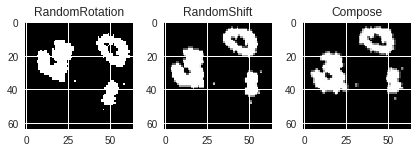

In [0]:
rotate = RandomRotation(20)
shift = RandomShift(3)
composed = transforms.Compose([RandomRotation(20),
                               RandomShift(3)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = transforms.ToPILImage()(X_train[65].reshape((64,64)).astype(np.uint8)[:,:,None])
for i, tsfrm in enumerate([rotate, shift, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,64)), cmap='gray')    

plt.show()

## Neural Network

In [0]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
       
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 16 * 16, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

In [0]:
model = Net()

optimizer = optim.Adadelta(model.parameters())

criterion = nn.CrossEntropyLoss()

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


## Training and Evaluation

In [0]:
!pip install livelossplot

from livelossplot import PlotLosses

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def train_model(model, criterion, optimizer, num_epochs=10):
    t0 = time.time()
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.draw()
        print('Time Elapsed: {}'.format(time.time() - t0))

## Train the model

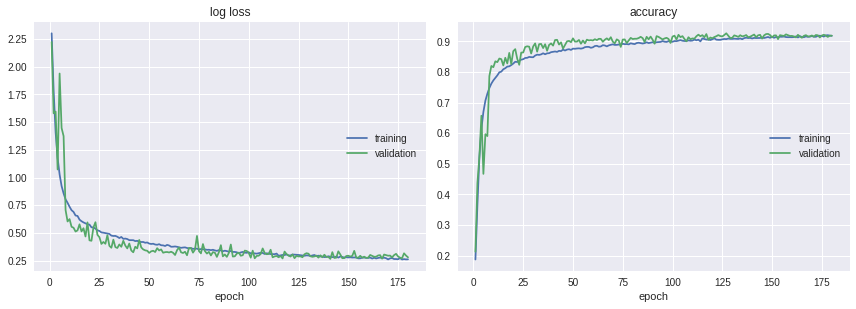

log loss:
training   (min:    0.260, max:    2.302, cur:    0.262)
validation (min:    0.266, max:    2.224, cur:    0.280)

accuracy:
training   (min:    0.187, max:    0.921, cur:    0.919)
validation (min:    0.213, max:    0.927, cur:    0.919)
Time Elapsed: 7983.920700073242


In [0]:
train_model(model, criterion, optimizer, num_epochs=180)


### Save the model

In [0]:
model_dir = 'models'
torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-full-{}.pth'.format(180)))

## Prediction

In [0]:
def prediction(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            data = Variable(data, volatile=True)
            if torch.cuda.is_available():
                data = data.cuda()

            output = model(data)

            pred = output.cpu().data.max(1, keepdim=True)[1]
            test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [0]:
test_pred = prediction(test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


In [0]:
out_df = pd.DataFrame(np.c_[np.arange(0, len(X_test))[:,None], test_pred.numpy()], 
                      columns=['Id', 'Category'])

In [0]:
out_df.to_csv('submission.csv', index=False)


In [0]:
from google.colab import files
files.download('submission.csv')